In [96]:
import json
import pandas as pd
import numpy as np
from collections import Counter
import openai
import os
from tqdm import tqdm
import time
openai.api_key = os.getenv("OPENAI_API_KEY")

In [97]:
def get_gpt_output(prompt, temperature=0, pp=0, max_tokens = 2048):
    try:
        conversation = [{'role': 'user', 'content': prompt}]
        response = openai.ChatCompletion.create(
            model="gpt-4-0613",
            messages=conversation,
            temperature=temperature,
            request_timeout=120,
            presence_penalty=pp,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0)
        content = response.choices[0]['message']['content']
        role = response.choices[0]['message']['role']
        conversation.append({'role': role, 'content': content})
        return conversation[-1]['content'], response
    except:
        print("*** ChatGPT has time out. If you see this message too many times, please consider stop ***")
        time.sleep(30)
        return get_gpt_output(prompt, temperature)

In [135]:
df = pd.read_csv('./resnet50/descriptions.csv')
NN_type = "ResNet-50"
uninterpretable_threshold = 0.16
profile = {item: {} for item in list(df["layer"].unique())}

In [136]:
df_interpretable = df[df["similarity"] > uninterpretable_threshold]
concepts_list = list(df_interpretable["description"].unique())

In [137]:
categories = ["object", "part", "scene", "material", "texture", "color", "unknown"]

In [138]:
concept2category_dict = {}
for i in tqdm(range(0, len(concepts_list), 20)):
    curr_concepts = ', '.join(concepts_list[i: i + 20])
    curr_prompt = f"""Example input:
    categorize the following concepts into the given categories, for concepts that are not interpretable words, categorize them into "unknown" category: 

    concepts: magenta, garrison, aa, teal, flying, stripe, hair, aluminum

    categories: object, part, scene, material, texture, color, unknown

    Example output:
    {{"magenta": "color", "aa": "unknown", "teal": "object", "flying": "scene", "stripe": "texture", "hair": "part", "aluminum": "material"}}

    Now, categorize the following concepts into the given categories, for concepts that are not interpretable words, categorize them into "unknown" category:

    concepts: {curr_concepts}

    categories: object, part, scene, material, texture, color, unknown
    """
    ret, response = get_gpt_output(curr_prompt)
    try:
        concept2category_dict.update(eval(ret))
    except:
        print("not expected output format, try again ...")
        ret, response = get_gpt_output(curr_prompt)
        concept2category_dict.update(eval(ret))

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [07:03<00:00, 13.24s/it]


In [139]:
df_interpretable["category"] = df_interpretable["description"].apply(lambda x: concept2category_dict[x])

C:\Users\yongc\AppData\Local\Temp\ipykernel_47036\984753025.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interpretable["category"] = df_interpretable["description"].apply(lambda x: concept2category_dict[x])


In [140]:
for layer_name in profile:
    index = list(df_interpretable[df_interpretable["layer"] == layer_name].groupby("category").count()["description"].index)
    for category in categories:
        if category in index:
            profile[layer_name][category] = df_interpretable[df_interpretable["layer"] == layer_name].groupby("category").count()["description"][category]
        else:
            profile[layer_name][category] = 0
uninterpretable_table = df[df["similarity"] <= uninterpretable_threshold].groupby("layer").count()["unit"]
for layer_name in profile:
    profile[layer_name]["uninterpretable"] = uninterpretable_table[layer_name]

[array([0, 1, 2, 3, 4, 5, 6, 7]), [0.15, 1.15, 2.15, 3.15, 4.15, 5.15, 6.15, 7.15], [0.3, 1.3, 2.3, 3.3, 4.3, 5.3, 6.3, 7.3], [0.44999999999999996, 1.45, 2.45, 3.45, 4.45, 5.45, 6.45, 7.45], [0.6, 1.6, 2.6, 3.6, 4.6, 5.6, 6.6, 7.6]]


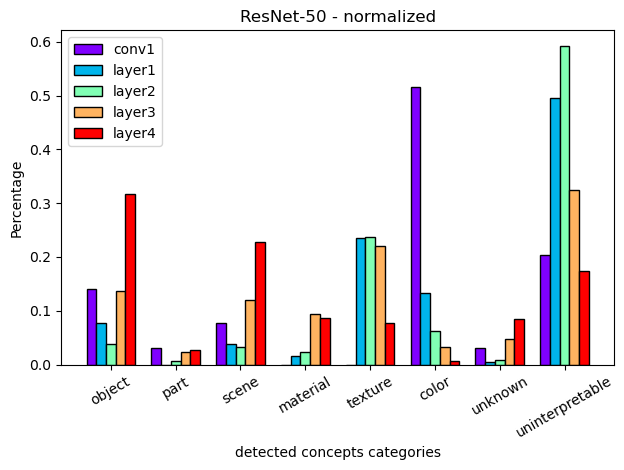

In [141]:
import matplotlib.pyplot as plt
import numpy as np
cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(profile)))
normalize = True
categories.append("uninterpretable")

# Given dictionaries
dict_values = []
for key in profile:
    curr_layer_dist = profile[key]
    labels = list(curr_layer_dist.keys())
    dict_values.append(list(curr_layer_dist.values()))
    
if normalize:
    for i in range(len(dict_values)):
        dict_values[i] = [item / sum(dict_values[i]) for item in dict_values[i]]

# Set bar width and positions
num_dicts = 5
bar_width = 0.15
r = []
r.append(np.arange(len(dict_values[0])))
for i in range(1, len(profile)):
    r.append([x + bar_width * i for x in r[0]])

print(r)
# Create bars
for i in range(len(profile)):
    plt.bar(r[i], dict_values[i], width = bar_width, color = colors[i], edgecolor = "black", label = list(profile.keys())[i])

#plt.bar(r[0], dict_values[0], label = "encoder")
# Label the axes and the plot
plt.xlabel('detected concepts categories')
plt.xticks([r + bar_width*2 for r in range(len(labels))], labels)  # Center the x-axis labels
#plt.xticks([r for r in range(len(labels))], labels)
plt.ylabel('Frequency')
if normalize:
    plt.ylabel('Percentage')
plt.title(f'{NN_type}')
if normalize:
    plt.title(f'{NN_type} - normalized')
plt.xticks(rotation=30)
# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.savefig('ResNet_50_profile.pdf', format='pdf')
plt.show()

# determine uninterpretable threshold

In [142]:
df = pd.read_csv('./ViT_b_16/descriptions.csv')

In [143]:
encoder_random_id_50 = [5, 11, 23, 28, 30, 31, 37, 45, 61, 81, 82, 113, 122, 124, 137, 139, 147, 186, 198, 225, 239, 251, 252, 271, 276, 308, 341, 356, 370, 398, 412, 416, 438, 460, 485, 517, 518, 536, 572, 576, 606, 614, 615, 633, 666, 667, 670, 690, 760, 767]
encoder_0_random_id_50 = [24, 36, 44, 58, 69, 107, 109, 128, 148, 196, 202, 216, 224, 231, 237, 252, 281, 282, 287, 290, 312, 318, 340, 342, 347, 371, 373, 386, 399, 402, 447, 460, 461, 467, 471, 564, 594, 615, 645, 672, 697, 704, 708, 715, 721, 741, 750, 751, 759, 765]
encoder_3_random_id_50 = [20, 29, 32, 79, 95, 100, 132, 159, 163, 169, 209, 217, 218, 230, 239, 240, 273, 282, 290, 327, 329, 356, 361, 376, 388, 462, 468, 474, 489, 505, 513, 515, 518, 529, 545, 547, 561, 584, 643, 644, 660, 675, 678, 690, 694, 709, 729, 743, 746, 747]
encoder_6_random_id_50 = [1, 8, 15, 29, 33, 45, 47, 50, 74, 89, 93, 94, 96, 110, 154, 224, 235, 277, 293, 299, 309, 310, 333, 365, 384, 391, 406, 413, 420, 424, 438, 460, 531, 546, 558, 588, 601, 622, 639, 643, 652, 658, 660, 663, 712, 715, 716, 732, 743, 765]
encoder_9_random_id_50 = [7, 8, 13, 30, 69, 74, 75, 101, 105, 133, 159, 176, 212, 239, 246, 282, 286, 294, 326, 330, 331, 332, 341, 343, 345, 357, 366, 368, 416, 429, 461, 512, 522, 538, 545, 550, 552, 555, 599, 608, 633, 643, 662, 672, 687, 706, 711, 716, 742, 745]

In [144]:
encoder_score_50 = [0, 1, 0, 1, 1, 1, 0.5, 1, 0.5, 0.5, 1, 0.5, 0, 0, 1, 0.5, 0, 1, 0.5, 0.5, 0.5, 1, 0, 0, 0, 0.5, 1, 0, 0, 0, 0.5, 0.5, 1, 0, 0, 0, 0.5, 0.5, 0, 1, 0.5, 1, 0.5, 0, 0, 1, 1, 1, 0, 1]
encoder_0_score_50 = [0.5, 0.5, 1, 1, 1, 1, 1, 0.5, 0.5, 0, 1, 0.5, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0.5, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0.5, 1, 0, 0, 1, 0, 0.5, 1, 1, 1, 0]
encoder_3_score_50 = [1, 0, 0.5, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0.5, 0, 0.5, 1, 0, 0.5, 1, 0, 0.5, 1, 0, 0, 0, 0, 0, 1, 0.5, 0, 0, 0, 0, 0.5, 1, 0, 0, 0, 0.5, 0, 1, 1, 0.5, 1, 1, 1, 1, 1]
encoder_6_score_50 = [1, 0, 1, 0, 0, 0, 0.5, 0.5, 0, 0.5, 1, 1, 0, 1, 0, 0, 0.5, 1, 0, 1, 0, 0.5, 1, 0, 1, 1, 0.5, 1, 1, 0.5, 0.5, 0, 0, 0.5, 0.5, 0, 0.5, 1, 1, 0, 1, 0.5, 1, 0.5, 0.5, 0.5, 0.5, 0.5, 0, 1]
encoder_9_score_50 = [0, 0, 0, 0.5, 1, 0, 0, 0, 0, 0.5, 0.5, 0.5, 0.5, 0.5, 1, 0, 0.5, 0, 1, 0, 0, 0.5, 0.5, 0.5, 0, 0.5, 0.5, 0, 0, 0.5, 0, 0, 0, 0.5, 0, 1, 0, 0, 0.5, 1, 0, 0.5, 0, 0.5, 0.5, 1, 0, 0.5, 1, 0.5]

In [55]:
df

,layer,unit,description,similarity
0,encoder,0,aquaculture,0.072388
1,encoder,1,stairs,0.081757
2,encoder,2,chefs,0.117432
3,encoder,3,screened,0.122528
4,encoder,4,corridors,0.212097
...,...,...,...,...
3835,encoder.layers.encoder_layer_9,763,antarctic,0.079468
3836,encoder.layers.encoder_layer_9,764,field,0.138641
3837,encoder.layers.encoder_layer_9,765,stairs,0.220490
3838,encoder.layers.encoder_layer_9,766,textile,0.101074


In [69]:
similarity.extend((list(df[(df["layer"] == "encoder.layers.encoder_layer_9") & (df["unit"].apply(lambda x: x in encoder_9_random_id_50))]["similarity"].values)))

In [76]:
scores.extend(encoder_9_score_50)

In [78]:
df_threshold = pd.DataFrame()
df_threshold["similarity"] = similarity
df_threshold["scores"] = scores

In [131]:
import numpy as np
print(np.mean(df_threshold["scores"].values))
np.mean(df_threshold[df_threshold["similarity"] > 0.16]["scores"].values)
len(df[df["similarity"] > 0.12]) / len(df)

0.51


0.6096354166666667